In [60]:
import argparse
import lzma
import os
import pickle
import sys
from typing import Optional
import urllib.request
import sklearn.compose
import sklearn.datasets
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.metrics
import sklearn.decomposition
import matplotlib.pyplot as plt
import warnings

import numpy as np
import numpy.typing as npt

In [6]:
name="thyroid_competition.train.npz"
dataset = np.load(name)
for key, value in dataset.items():
    setattr(dataset, key, value)

In [13]:
np.random.seed(42)
train = dataset.data

(array([ 22., 152., 390., 537., 431., 534., 737., 609., 299.,  61.]),
 array([0.01 , 0.103, 0.196, 0.289, 0.382, 0.475, 0.568, 0.661, 0.754,
        0.847, 0.94 ]),
 <BarContainer object of 10 artists>)

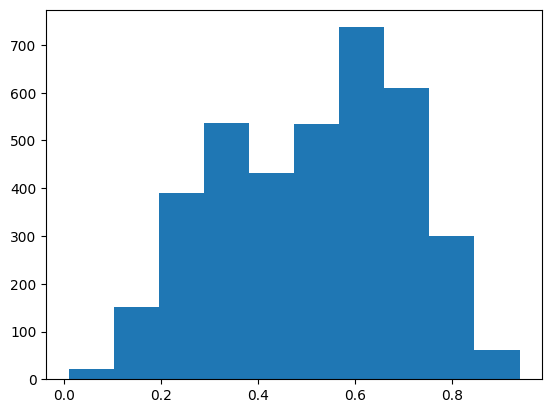

In [32]:
plt.hist(dataset.data[:, 15])

In [44]:
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)

In [255]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.data, dataset.target, test_size=0.2, random_state=42)

In [279]:
col_int = np.all(X_train.astype(int) == X_train, axis=0)
transformer = sklearn.compose.ColumnTransformer([("Cat", sklearn.preprocessing.OneHotEncoder(sparse=False, handle_unknown="ignore"), col_int), ("Std", sklearn.preprocessing.StandardScaler(), ~col_int)])
polynomial = sklearn.preprocessing.PolynomialFeatures(include_bias=False)
pca = sklearn.decomposition.PCA()
model = sklearn.linear_model.LogisticRegression(random_state=42)
pipeline = sklearn.pipeline.Pipeline([("transformer", transformer), ("polynomial", polynomial), ('pca', pca), ('logistic reg', model)])    

In [366]:
CV = sklearn.model_selection.GridSearchCV(pipeline, {'polynomial__degree':[3], 'logistic reg__C':[1000, 2000], "pca__n_components": [1000, 1500]}, 
                                    cv = sklearn.model_selection.StratifiedKFold(5), refit = True)

(3772, 21)


In [368]:
model = CV.fit(dataset.data, dataset.target)


In [369]:
for rank, accuracy, params in zip(model.cv_results_["rank_test_score"],
    model.cv_results_["mean_test_score"],
    model.cv_results_["params"]):
    print("Rank: {:2d} Cross-val: {:.1f}%".format(rank, 100 * accuracy),
    *("{}: {:<5}".format(key, value) for key, value in params.items()))


Rank:  3 Cross-val: 98.4% logistic reg__C: 1000  pca__n_components: 1000  polynomial__degree: 3    
Rank:  3 Cross-val: 98.4% logistic reg__C: 1000  pca__n_components: 1500  polynomial__degree: 3    
Rank:  1 Cross-val: 98.4% logistic reg__C: 2000  pca__n_components: 1000  polynomial__degree: 3    
Rank:  1 Cross-val: 98.4% logistic reg__C: 2000  pca__n_components: 1500  polynomial__degree: 3    


In [370]:
test_accuracy = model.score(X_test, y_test)
test_accuracy

1.0

In [183]:
train_accuracy = sklearn.metrics.accuracy_score(y_test, pred)
train_accuracy

0.9854304635761589